In [1]:
%load_ext autoreload 
%autoreload 2 
%matplotlib inline
#---------------------------------------------------------------------------------
import numpy as np
import pylab as pl
import astropy.io.fits as pyfits
import sys
import os
import cPickle
#-------------------------------------theano & lasagne----------------------------
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import Conv2DLayer as conv
from lasagne.layers import MaxPool2DLayer as pool
from lasagne.layers import DenseLayer as dense
from lasagne.nonlinearities import rectify
from lasagne.regularization import l2, regularize_layer_params

/home/nli/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5103)
/home/nli/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#---------------------------------------------------------------------------------
# Define functions to Write and Read models
#

def ReadModelFromFile(model, filename):
    if not os.path.isfile(filename):
        print (filename, "not exist")
        sys.exit(-1)
    f = open(filename, 'r')
    data = cPickle.load(f)
    lasagne.layers.set_all_param_values(model, data)


def WriteModelToFile(model, filename):
    data = lasagne.layers.get_all_param_values(model)
    with open(filename, 'w') as f:
        cPickle.dump(data, f)

In [3]:
#---------------------------------------------------------------------------------
# Define a function to build a CNN
#

def BuildModel(x, img_size):
    filter_size = [3,3,3,3,3,3]      # 3x3 or 5x5
    pool_size =   [1,2,2,2,2,2]      # pooling

    num_filters = [16, 16, 32, 32, 32, 32]

    n_layers = len(filter_size)
    if any( [len(pool_size) != n_layers, len(num_filters)!=n_layers] ):
        raise ValueError('num of layers should be consistent')

    n_hiddens = [50, 100]      #[50, 50]        public

    model = lasagne.layers.InputLayer(shape=(None, 1, img_size, img_size), input_var=x)

    for i in xrange(n_layers):
        model = conv( model, num_filters=num_filters[i], filter_size=(filter_size[i], filter_size[i]),
                     nonlinearity=rectify, W=lasagne.init.GlorotUniform(), pad='same')
        if pool_size[i] > 1:
            model = pool(model, pool_size=(pool_size[i],pool_size[i]))

    for i in xrange( len(n_hiddens) ):
        model = dense(model, num_units = n_hiddens[i], nonlinearity=rectify)
    model = dense(model, num_units=1, nonlinearity=rectify)
    return model

In [4]:
#---------------------------------------------------------------------------------
# Define a function to train the model
#

def Fit(model, train_model, X_train, Y_train, N_EPOCH, batch_train,
        valid_model, X_valid, Y_valid, batch_valid,
        write_to='./'):

    n_round = X_train.shape[0]/ batch_train + (X_train.shape[0] % batch_train > 0)

    loss_train = []
    loss_valid = []

    for e in xrange(N_EPOCH):
        sys.stdout.write("\r%d / %d" % (e+1, N_EPOCH ) )
        sys.stdout.flush()

        loss_epoch = []
        for idx in xrange( n_round ):
            start_index = idx * batch_train; end_index = (idx+1) * batch_train
            if end_index > X_train.shape[0]-1:
                end_index = X_train.shape[0]-1
            if start_index >= end_index:
                continue
            tmp = train_model(X_train[start_index:end_index], Y_train[start_index:end_index])
            loss_epoch.append( np.array( tmp ) )
        loss_train.append( np.mean( np.row_stack(loss_epoch), 0 ) )

        WriteModelToFile(model, os.path.join(write_to, str(e+1)+'.pkl') )

        if valid_model is None:
            continue
        if X_valid is None or Y_valid is None:
            raise ValueError('if valid_mode is not None, X_valid or Y_valid cannot be None')

        n_round_valid = X_valid.shape[0]/ batch_valid + (X_valid.shape[0] % batch_valid > 0)

        loss_epoch = []
        for idx in xrange( n_round_valid ):
            start_index = idx * batch_valid; end_index = (idx+1) * batch_valid
            if end_index > X_valid.shape[0]-1:
                end_index = X_valid.shape[0]-1
            if start_index >= end_index:
                continue
            tmp = valid_model(X_valid[start_index:end_index], Y_valid[start_index:end_index])
            loss_epoch.append( np.array( tmp ) )
        loss_valid.append( np.mean( np.row_stack(loss_epoch), 0 ) )

    loss_train = np.array(loss_train)
    if len( loss_valid ) >= 1:
        loss_valid = np.array(loss_valid)
        return loss_train, loss_valid
    return loss_train

In [5]:
#---------------------------------------------------------------------------------
# Define a function to create readable data for the training function
#

def create_xy(num_imgs, fits_dir, par_cat):

    images = []
    for i in xrange(num_imgs):
        fname = fits_dir+str(i)+".fits"
        itmp = pyfits.getdata(fname)
        images.append(np.array(itmp).astype("float32"))

    images = np.array(images)
    
    # Visualize the images
    fig = pl.figure( figsize= (15, 15) )
    fig.add_subplot(331)
    pl.imshow(images[0], cmap=pl.cm.viridis)
    fig.add_subplot(332)
    pl.imshow(images[1], cmap=pl.cm.viridis)
    fig.add_subplot(333)
    pl.imshow(images[2], cmap=pl.cm.viridis)
    fig.add_subplot(334)
    pl.imshow(images[3], cmap=pl.cm.viridis)
    fig.add_subplot(335)
    pl.imshow(images[4], cmap=pl.cm.viridis)
    fig.add_subplot(336)
    pl.imshow(images[5], cmap=pl.cm.viridis)
    fig.add_subplot(337)
    pl.imshow(images[6], cmap=pl.cm.viridis)
    fig.add_subplot(338)
    pl.imshow(images[7], cmap=pl.cm.viridis)
    fig.add_subplot(339)
    pl.imshow(images[8], cmap=pl.cm.viridis)
    #------------------------

    x_all = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
    del images
    y_all = np.loadtxt(par_cat)
    y_all = y_all.astype("float32")

    y_all_sig = ( y_all[:,0][:num_imgs] - 0.5 ) / 1.5 * 100.0     # sigma
    y_all_ell = ( y_all[:,1][:num_imgs] - 0.5 ) / 0.5 * 100.0     # ell
    y_all_pha = ( y_all[:,2][:num_imgs] )/360.0*100.0             # pha

    return x_all, y_all_ell

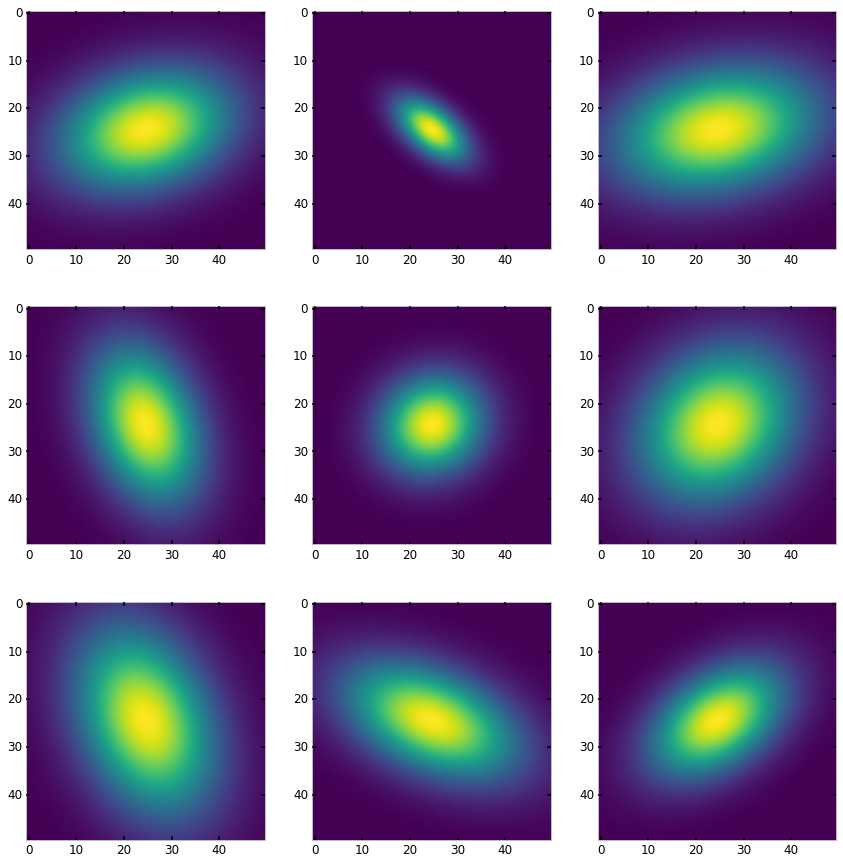

In [6]:
#----------------------------------------------------------------------------------
# Create Training Sets, Valid sets, and Testing Sets
#

num_imgs = 1000

fits_dir = "/media/luna2/nanli/deepLearningWorkingDir/NanLi/ell_galaxy_ml/data/fitsImages/"
X, Y = create_xy(num_imgs, fits_dir, "./data/parameters.dat")
img_size = 50

frat = 0.8
ftst = 0.1
train_index = range(0, int(frat * num_imgs))
valid_index = range(int(frat * num_imgs), int((frat+ftst) * num_imgs))
tests_index = range(int((frat+ftst) * num_imgs), num_imgs)

train_x = X[train_index]
train_y = Y[train_index]
valid_x = X[valid_index]
valid_y = Y[valid_index]
tests_x = X[tests_index]
tests_y = Y[tests_index]   

In [7]:
#----------------------------------------------------------------------------------
# Create the model and the variables for the function of FIT
#

x = T.tensor4('input image')
y = T.vector('output')
l_out = BuildModel(x, img_size)
pred_train = lasagne.layers.get_output(l_out, deterministic=False)
pred_valid = lasagne.layers.get_output(l_out, deterministic=True)

In [8]:
#----------------------------------------------------------------------------------
# Setup basic parameters for the regression 
#

N_EPOCH = 100
lambda_reg = 0.0001
batch_train = 1
batch_valid = 1
model_dir = "./models_outputs/"
    
# Initialize the loss of training
mse_loss_train = lasagne.objectives.squared_error(y, pred_train)
reg_loss = regularize_layer_params(l_out, l2) * lambda_reg
loss = T.mean(mse_loss_train) + reg_loss

# Initialize the parameters and define the updates
params = lasagne.layers.get_all_params(l_out, trainable=True, regularizable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.0001)

# Define the training model
train_model = theano.function([x, y], [loss, mse_loss_train.mean(), reg_loss], updates=updates)

# Initilaize the loss of Valid
mse_loss_valid = lasagne.objectives.squared_error(y, pred_valid)
valid_model = theano.function([x, y], [loss, mse_loss_valid.mean()])

In [9]:
#----------------------------------------------------------------------------------
# Start training
#

loss_train, loss_valid = Fit(l_out, train_model, train_x, train_y, N_EPOCH, batch_train,
                                 valid_model, valid_x, valid_y, batch_valid,
                                 write_to=model_dir)
    

100 / 100

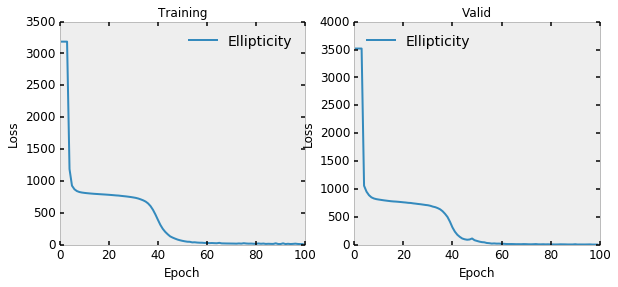

In [10]:
#----------------------------------------------------------------------------------
# Visualize the loss of training and valid
#

fig = pl.figure(figsize=(10, 4))

fig.add_subplot(121)
pl.plot(loss_train[:,0], '-')
pl.title('Training')
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.legend(("Ellipticity",), loc='upper right', shadow=True, fontsize=14)

fig.add_subplot(122)
pl.plot(loss_valid[:,0], '-')
pl.title('Valid')
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.legend(("Ellipticity",), loc='upper left', shadow=True, fontsize=14)

In [11]:
#----------------------------------------------------------------------------------
# Check the match between inputs and predictions
#

# Define the model
f_pred = theano.function([x], pred_valid)
y_pred = f_pred(X[:])
    
# Define the outputs
y_train = np.array(y_pred)[train_index, 0]
y_valid = np.array(y_pred)[valid_index, 0]
y_tests = np.array(y_pred)[tests_index, 0]

# Load in the model
ReadModelFromFile(l_out, filename=model_dir+'/93.pkl')    

/home/nli/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


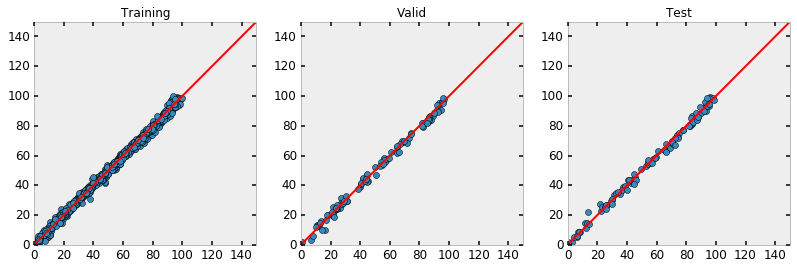

In [12]:
#----------------------------------------------------------------------------------
# Visualize the match of the training set, valid set, and testing set
#

fig = pl.figure(figsize= (14, 4))

fig.add_subplot(131)
pl.title('Training')
pl.plot(y_train, train_y, 'o')
pl.plot(np.linspace(0,149,150), np.linspace(0,149,150), "r-")
pl.axis([0, 150, 0, 150])

fig.add_subplot(132)
pl.title('Valid')
pl.plot(y_valid, valid_y, 'o')
pl.plot(np.linspace(0,149,150), np.linspace(0,149,150), "r-")
pl.axis([0, 150, 0, 150])

fig.add_subplot(133)
pl.title('Test')
pl.plot(y_tests, tests_y, 'o')
pl.plot(np.linspace(0,149,150), np.linspace(0,149,150), "r-")
pl.axis([0, 150, 0, 150])

pl.legend()